In [76]:
from sklearn.datasets import fetch_openml
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep
from phate import PHATE

from sklearn.model_selection import train_test_split

In [77]:
# data = fetch_openml(name='tic-tac-toe', version=1, as_frame=True)

# x = data['data']
# y = data['target']
# y = pd.Categorical(y).codes
# x = dataprep(x, label_col_idx = None, scale = None)

In [78]:
# data   = pd.read_csv('../datasets/2_class_normal.csv', sep = ',')
data   = pd.read_csv('../datasets/titanic.csv', sep = ',')
x, y   = dataprep(data)
n, d   = x.shape
n_classes = len(y.unique())

In [79]:
x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n), test_size=0.1, random_state = 42)

In [80]:
rf = RFGAP(oob_score = True, non_zero_diagonal = False, random_state = 42) #non_zero_diagonal must be false
rf.fit(x, y)
prox = rf.get_proximities()

In [81]:
rf2 = RFGAP(oob_score = True, non_zero_diagonal = True, random_state = 42) #non_zero_diagonal must be false for trust
rf2.fit(x, y)
prox2 = rf2.get_proximities()

In [82]:
rf3 = RFGAP(oob_score = True, non_zero_diagonal = False, random_state = 42)
rf3.fit(x_train, y_train)
prox3 = rf3.get_proximities()

In [83]:
trust_scores = rf.get_trust_scores()
trust_scores_test = rf3.get_test_trust(x_test)

In [84]:
rf3.is_correct_oob.shape

(640,)

In [85]:
rf3.oob_proba.shape

(640, 2)

In [86]:
(rf3.test_proximities @ rf3.is_correct_oob).shape

(72,)

<Axes: ylabel='Density'>

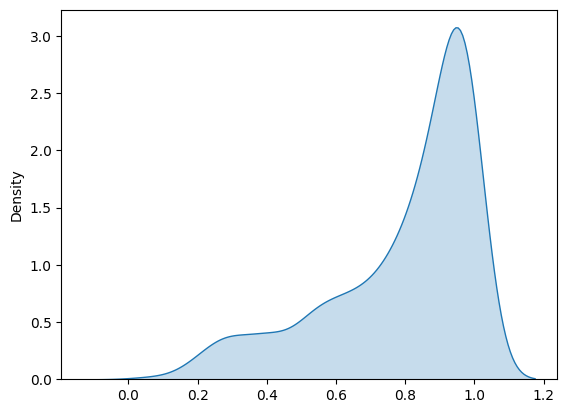

In [87]:
sns.kdeplot(trust_scores, fill = True)

<Axes: ylabel='Count'>

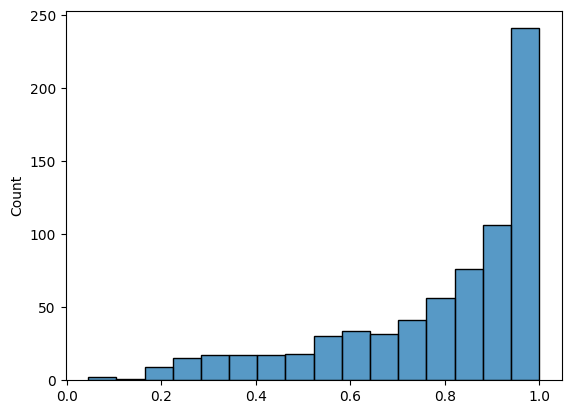

In [88]:
sns.histplot(trust_scores)

In [89]:
x['trust'] = rf.trust_correct_proba
x['class'] = y

In [90]:
# sns.pairplot(x, hue = 'class', plot_kws = {'s': 10})

In [91]:
def rescale(x):
    return 100 - (x - x.min())/(x.max() - x.min()) * 100 + 5

In [92]:
phate_op = PHATE(knn_dist = 'precomputed')
emb = phate_op.fit_transform(prox2)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 712 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating optimal t...


    Automatically selected t = 22
  Calculated optimal t in 0.15 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.07 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.51 seconds.
Calculated PHATE in 0.75 seconds.


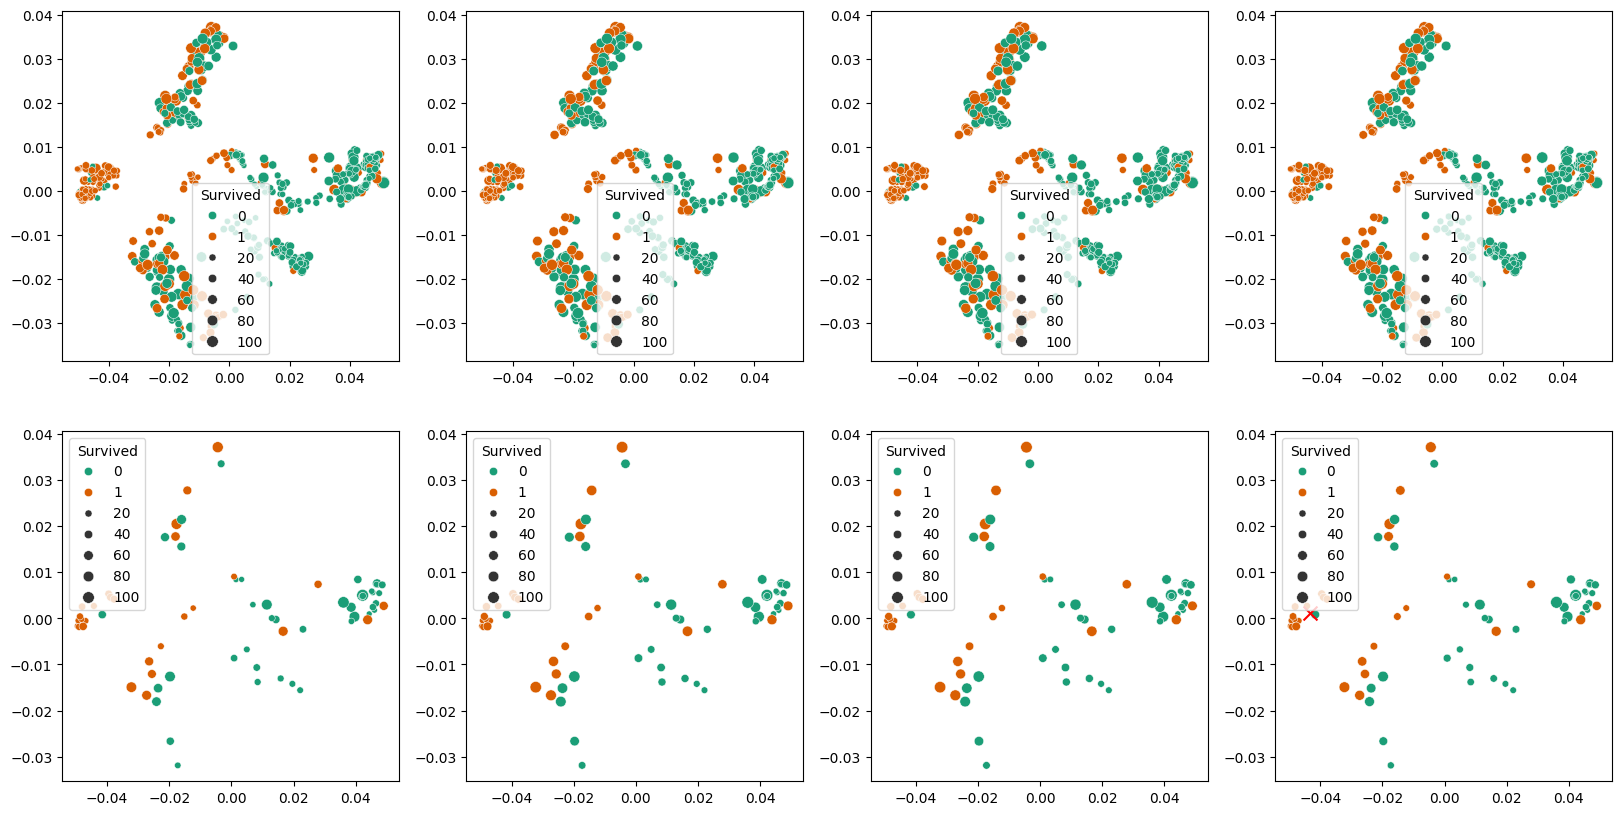

In [93]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))

sns.scatterplot(ax = axes[0, 0], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_scores), palette = 'Dark2')
sns.scatterplot(ax = axes[0, 1], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_correct_proba), palette = 'Dark2')
sns.scatterplot(ax = axes[0, 2], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_max_proba), palette = 'Dark2') 
sns.scatterplot(ax = axes[0, 3], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_minus), palette = 'Dark2')

sns.scatterplot(ax = axes[1, 0], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_scores_test), palette = 'Dark2')
sns.scatterplot(ax = axes[1, 1], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_correct_proba_test), palette = 'Dark2')
sns.scatterplot(ax = axes[1, 2], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_max_proba_test), palette = 'Dark2') 
sns.scatterplot(ax = axes[1, 3], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_minus_test), palette = 'Dark2')

plt.scatter(emb[483, 0], emb[483, 1], s = 100, c = 'r', marker = 'x')



<Axes: >

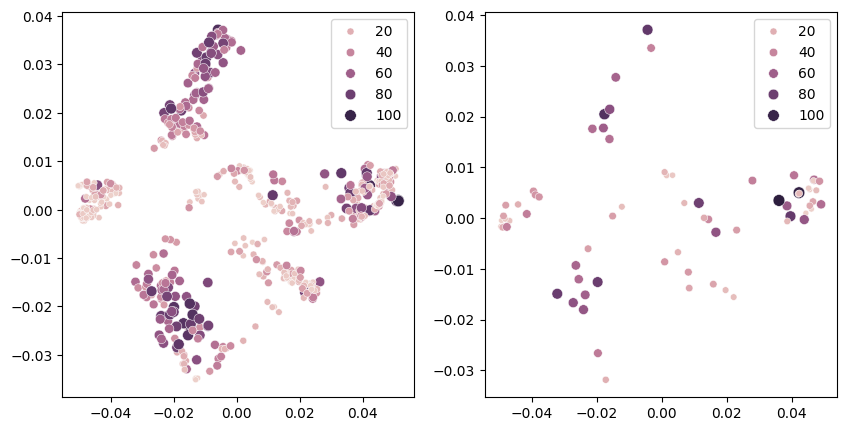

In [94]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.scatterplot(ax = axes[0], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.trust_scores), size = rescale(rf.trust_scores))
sns.scatterplot(ax = axes[1], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = rescale(rf3.trust_minus_test), size = rescale(rf3.trust_minus_test))

# plt.scatter(emb[49, 0], emb[49, 1], s = 100, c = 'r', marker = 'x')
# plt.scatter(emb[72, 0], emb[72, 1], s = 100, c = 'g', marker = 'x')

In [95]:
rf3.oob_score_

0.7890625

In [96]:
x['oob_correct'] = rf.is_correct_oob

In [97]:
x.groupby('oob_correct').mean()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,trust,class
oob_correct,,,,,,,,,
False,0.635762,0.655629,0.366161,0.084768,0.049669,0.069213,0.705298,0.459922,0.523179
True,0.615865,0.631016,0.367485,0.107665,0.078134,0.067002,0.822638,0.755271,0.372549


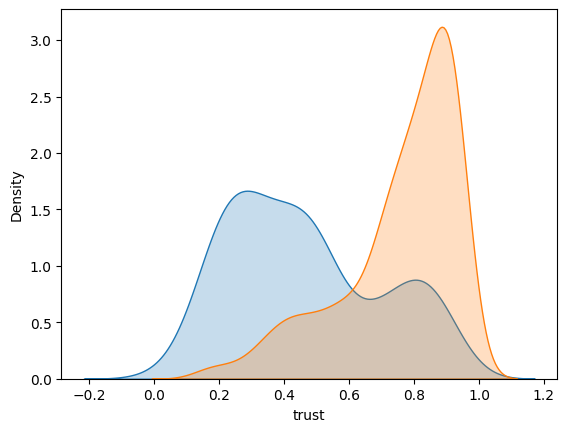

In [98]:
for group in x.groupby('oob_correct'):
    sns.kdeplot(group[1]['trust'], fill = True)

<Axes: xlabel='trust', ylabel='Density'>

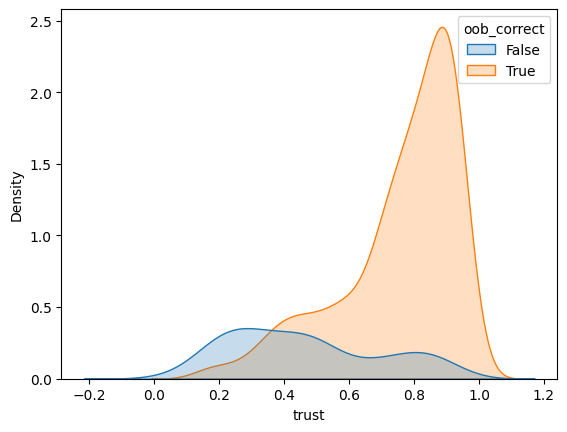

In [99]:
sns.kdeplot(data = x, hue = 'oob_correct', x = 'trust', fill = True)

<Axes: xlabel='Pclass', ylabel='Sex'>

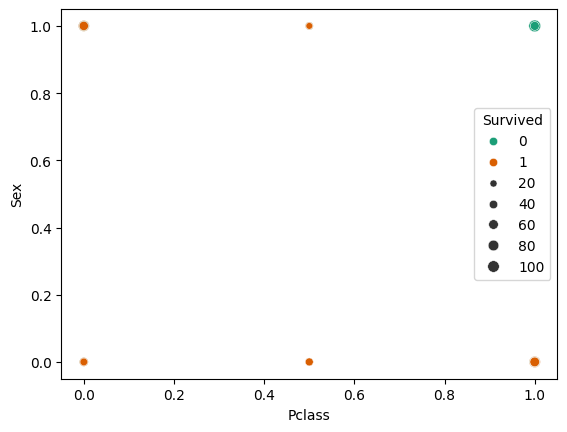

In [100]:
sns.scatterplot(x = x.iloc[inds_test, 0], y = x.iloc[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_minus_test), palette = 'Dark2')

<Axes: xlabel='Pclass', ylabel='Sex'>

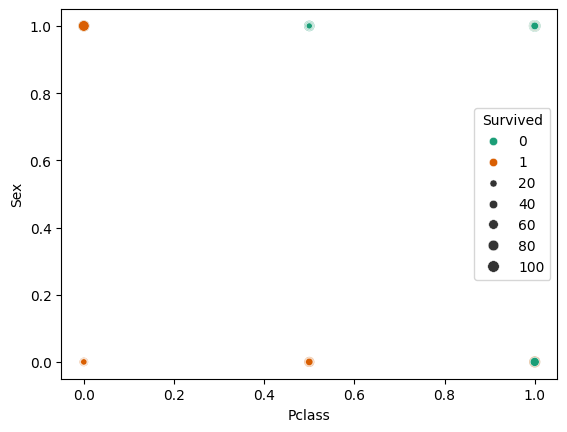

In [101]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = y, size = rescale(rf.trust_scores), palette = 'Dark2')

In [102]:
inds_test[np.argmin(rf3.trust_scores_test)]

49

In [103]:
inds_test[np.argmax(rf3.trust_scores_test)]

72

In [104]:
# TODO: Experiment: make bivariate blobs, but put a point in the middle of the
# opposite blob class. Then, check if the trust score is low for that point under
# a few conditions: 1) with raw trust, 2) with raw trust multiplied by max proba
# 3) with raw trust mutliplied by correct proba.

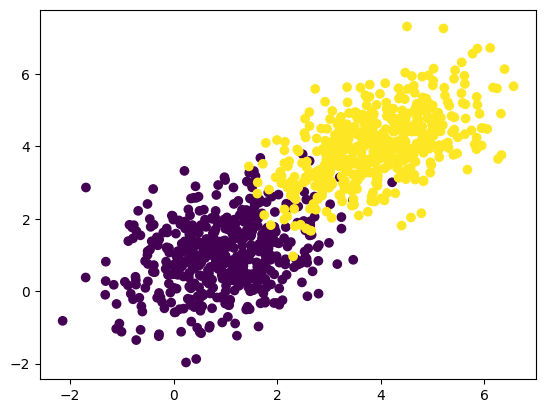

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(42)

# Generate data for class 1
mu1 = [1, 1]
cov1 = [[1, 0.3], [0.3, 1]]
data1 = np.random.multivariate_normal(mu1, cov1, 500)

# Generate data for class 2
mu2 = [4, 4]
cov2 = [[1, 0.6], [0.6, 1]]
data2 = np.random.multivariate_normal(mu2, cov2, 500)

# Combine the data and create labels
X = np.vstack((data1, data2))
y = np.hstack((np.zeros(500), np.ones(500)))

# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [106]:
data = np.column_stack((y, X))

In [107]:
# np.savetxt('../datasets/2_class_normal.csv', data, delimiter = ',')